In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_openml
from ucimlrepo import fetch_ucirepo
import seaborn as sns
import matplotlib.pyplot as plt

Starsza nasza

In [2]:
def soft_thresholding(a, b):
    return np.sign(a) * np.maximum(np.abs(a) - b, 0)

def one_hot_encode(y, num_classes=None):
    y = np.array(y)
    if num_classes is None:
        num_classes = np.max(y) + 1
    
    one_hot = np.zeros((len(y), num_classes))
    one_hot[np.arange(len(y)), y] = 1
    return one_hot


class logisitic_regression():
    def __init__(self):
        pass
    
    def set_std_mean(self,X, epsilon = 1e-8):
        self.mean = np.mean(X, axis = 0)
        std = np.std(X,axis = 0)
        self.std = np.where(std > 0, std, epsilon)

    def standarize(self, X):
        return (X-self.mean)/self.std

    def fit(self, X, y, a, epsilon = 0.001, K=100, weights = False, lambdas = None):
        X, y = np.array(X), np.array(y)
        n, p = X.shape
        self.set_std_mean(X)
        X = self.standarize(X)
        y = one_hot_encode(y)
        g = y.shape[1]
        self.B = X.T@y/n
        if not lambdas: 
            lambda_max= np.max(np.abs(self.B))
            if a != 0:
                lambda_max /= a
            lambdas = np.logspace(np.log10(lambda_max), np.log10(epsilon*lambda_max), K)

        for lambd in lambdas:
            for k in range(g):
                for j in range(p):
                    w_sum = 1
                    w_sumx2 = 1
                    xj = X[:,j]
                    if weights:
                        preds = self.predict_proba(X)[:,k]
                        w = preds*(1-preds)
                        w_sumx2 = w@(xj*xj)
                        w_sum=np.sum(w)
                        xj = w*xj
                    sum = (xj@(y[:,k])) - xj@X@(self.B[:,k]) + w_sum*self.B[j,k]
                    self.B[j,k]= soft_thresholding(sum/n,lambd*a)/(w_sumx2+lambd*(1-a))

    def predict_proba(self, X):
        X = np.array(X)
        X = self.standarize(X)
        X = np.exp(X@self.B)
        return X / X.sum(axis=1, keepdims=True)
    
    def predict(self, X):
        predictions = self.predict_proba(X)
        return np.argmax(predictions, axis = 1)

Nowa nasza

In [18]:
def soft_thresholding(a, b):
    return np.sign(a) * np.maximum(np.abs(a) - b, 0)

def one_hot_encode(y, num_classes=None):
    y = np.array(y)
    if num_classes is None:
        num_classes = np.max(y) + 1
    one_hot = np.zeros((len(y), num_classes))
    one_hot[np.arange(len(y)), y] = 1
    return one_hot

class MyLogisticRegression():
    def __init__(self):
        self.mean = None
        self.std = None
        self.B = None
    
    def set_std_mean(self, X, epsilon=1e-8):
        self.mean = np.mean(X, axis=0)
        std = np.std(X, axis=0)
        self.std = np.where(std > 0, std, epsilon)

    def standardize(self, X):
        return (X - self.mean) / self.std
    

    def fit(self, X, y, a=1.0, epsilon=0.001, K=100, weights=False, lambdas=None):
        X, y = np.array(X), np.array(y)
        n, p = X.shape
        self.set_std_mean(X)
        X = self.standardize(X)
        y = one_hot_encode(y)
        g = y.shape[1]
        
        self.B = np.zeros((p, g))
        
        if lambdas is None:
            lambda_max = np.max(np.abs(X.T @ y / n))
            if a != 0:
                lambda_max /= a
            lambdas = np.logspace(np.log10(lambda_max), np.log10(epsilon * lambda_max), K)
        
        for lambd in lambdas:
            for k in range(g):
                for j in range(p):
                    xj = X[:, j]
                    w_sum = 1
                    w_sumx2 = 1
                    
                    if weights:
                        preds = self.predict_proba(X)[:, k]
                        w = preds * (1 - preds)
                        w_sumx2 = w @ (xj * xj)
                        w_sum = np.sum(w)
                        xj = w * xj
                    
                    sum_val = (xj @ y[:, k]) - (xj @ X @ self.B[:, k]) + w_sum * self.B[j, k]
                    self.B[j, k] = soft_thresholding(sum_val / n, lambd * a) / (w_sumx2 + lambd * (1 - a))
    
    def predict_proba(self, X):
        X = np.array(X)
        X = self.standardize(X)
        X = np.exp(X @ self.B)
        return X / X.sum(axis=1, keepdims=True)
    
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

Z sklearn

In [4]:
from sklearn.linear_model import LogisticRegression

In [ ]:
# def standardize_data(X):
#     scaler = StandardScaler()
#     X_scaled = scaler.fit_transform(X)
#     return pd.DataFrame(X_scaled, columns=X.columns)

In [5]:
def is_high_corr(corr):
    high_corr = (corr> 0.75) | (corr < -0.75)

    for i in range(len(corr)):
        for j in range(i + 1, len(corr)):
            if high_corr.iloc[i, j]:
                print(f"{corr.index[i]}, {corr.columns[j]}: {corr.iloc[i, j]:.2f}")

In [6]:
def add_artificial_variables(df, min_feature_ratio=0.5):
    num_rows = df.shape[0]
    required_features = int(num_rows * min_feature_ratio) - df.shape[1]
    for i in range(required_features):
        permuted_column = df.sample(frac=1, axis=1).iloc[:, 0]
        df[f"artificial_{i}"] = permuted_column
    return df

Zbiór ionosphere

In [7]:
ionosphere = fetch_ucirepo(id=52) 

In [8]:
X=ionosphere.data.features
X

,Attribute1,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9,Attribute10,...,Attribute25,Attribute26,Attribute27,Attribute28,Attribute29,Attribute30,Attribute31,Attribute32,Attribute33,Attribute34
0,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,...,0.56811,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300
1,1,0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,...,-0.20332,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447
2,1,0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,...,0.57528,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238
3,1,0,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,...,1.00000,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000
4,1,0,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,...,0.03286,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,1,0,0.83508,0.08298,0.73739,-0.14706,0.84349,-0.05567,0.90441,-0.04622,...,0.95378,-0.04202,0.83479,0.00123,1.00000,0.12815,0.86660,-0.10714,0.90546,-0.04307
347,1,0,0.95113,0.00419,0.95183,-0.02723,0.93438,-0.01920,0.94590,0.01606,...,0.94520,0.01361,0.93522,0.04925,0.93159,0.08168,0.94066,-0.00035,0.91483,0.04712
348,1,0,0.94701,-0.00034,0.93207,-0.03227,0.95177,-0.03431,0.95584,0.02446,...,0.93988,0.03193,0.92489,0.02542,0.92120,0.02242,0.92459,0.00442,0.92697,-0.00577
349,1,0,0.90608,-0.01657,0.98122,-0.01989,0.95691,-0.03646,0.85746,0.00110,...,0.91050,-0.02099,0.89147,-0.07760,0.82983,-0.17238,0.96022,-0.03757,0.87403,-0.16243


In [9]:
# X=standardize_data(X)
# X

In [10]:
X.isna().sum()

Attribute1     0
Attribute2     0
Attribute3     0
Attribute4     0
Attribute5     0
Attribute6     0
Attribute7     0
Attribute8     0
Attribute9     0
Attribute10    0
Attribute11    0
Attribute12    0
Attribute13    0
Attribute14    0
Attribute15    0
Attribute16    0
Attribute17    0
Attribute18    0
Attribute19    0
Attribute20    0
Attribute21    0
Attribute22    0
Attribute23    0
Attribute24    0
Attribute25    0
Attribute26    0
Attribute27    0
Attribute28    0
Attribute29    0
Attribute30    0
Attribute31    0
Attribute32    0
Attribute33    0
Attribute34    0
dtype: int64

In [11]:
y=ionosphere.data.targets
print(y.value_counts())
y=np.array(y).T[0]
y=(y=="g").astype(int)
y

Class
g        225
b        126
Name: count, dtype: int64


array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

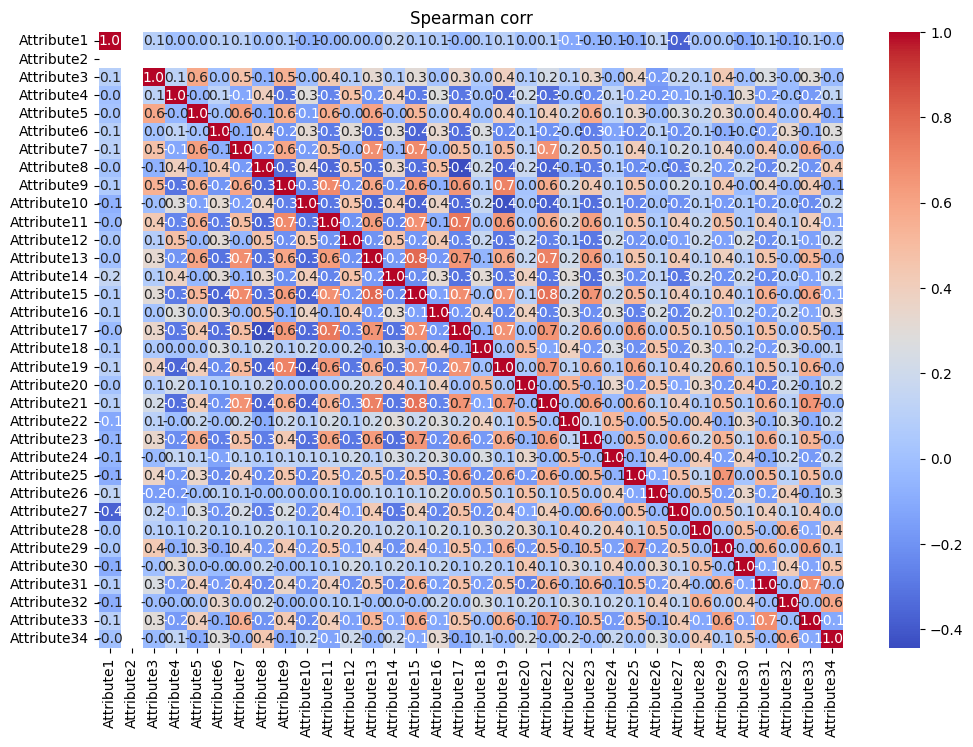

In [12]:
corr_spearman = X.corr(method='spearman')
plt.figure(figsize=(12, 8)) 
sns.heatmap(corr_spearman, annot=True, cmap='coolwarm', fmt='.1f')

plt.title('Spearman corr')
plt.show()

We can assume we don't have strong collinearity between variables

In [13]:
X=add_artificial_variables(X)

C:\Users\Kuba\AppData\Local\Temp\ipykernel_18456\521130096.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"artificial_{i}"] = permuted_column
C:\Users\Kuba\AppData\Local\Temp\ipykernel_18456\521130096.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"artificial_{i}"] = permuted_column
C:\Users\Kuba\AppData\Local\Temp\ipykernel_18456\521130096.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all

In [14]:
X

,Attribute1,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9,Attribute10,...,artificial_131,artificial_132,artificial_133,artificial_134,artificial_135,artificial_136,artificial_137,artificial_138,artificial_139,artificial_140
0,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,...,0.56971,0.85243,0.56971,0.42267,-0.46168,-0.45300,0.41078,-0.44945,0.84356,0.41078
1,1,0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,...,-0.13151,0.50874,-0.13151,-0.16626,-0.18401,-0.02447,-0.20468,-0.69707,0.05499,-0.20468
2,1,0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,...,0.70887,0.73082,0.70887,0.60436,-0.22145,-0.38238,0.58984,0.00827,0.83775,0.58984
3,1,0,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,...,-0.69975,0.00000,-0.69975,0.25682,1.00000,1.00000,0.51613,0.00000,0.54094,0.51613
4,1,0,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,...,0.05982,0.52798,0.05982,-0.05707,-0.53206,-0.65697,0.13290,-0.00712,0.52940,0.13290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,1,0,0.83508,0.08298,0.73739,-0.14706,0.84349,-0.05567,0.90441,-0.04622,...,0.87605,0.89391,0.87605,0.86660,0.00123,-0.04307,0.83479,0.06723,1.00000,0.83479
347,1,0,0.95113,0.00419,0.95183,-0.02723,0.93438,-0.01920,0.94590,0.01606,...,0.92670,0.96510,0.92670,0.94066,0.04925,0.04712,0.93522,0.07330,0.97173,0.93522
348,1,0,0.94701,-0.00034,0.93207,-0.03227,0.95177,-0.03431,0.95584,0.02446,...,0.91406,0.94124,0.91406,0.92459,0.02542,-0.00577,0.92489,0.04688,0.94837,0.92489
349,1,0,0.90608,-0.01657,0.98122,-0.01989,0.95691,-0.03646,0.85746,0.00110,...,0.88729,0.89724,0.88729,0.96022,-0.07760,-0.16243,0.89147,-0.01436,0.91381,0.89147


In [15]:
old_lr=logisitic_regression()
old_lr.fit(X,y,a = 0, epsilon=0.001)
pred1_old=old_lr.predict(X)
np.mean(y == pred1_old)

np.float64(0.717948717948718)

In [19]:
my_lr = MyLogisticRegression()
my_lr.fit(X,y,a = 0, epsilon=0.001)
pred1_my = my_lr.predict(X)
np.mean(y == pred1_my)

np.float64(0.8689458689458689)

In [20]:
model_sk = LogisticRegression(solver='liblinear', penalty='l1', max_iter=100)
model_sk.fit(X,y)
pred1_sk=model_sk.predict(X)
np.mean(y == pred1_sk)

np.float64(0.9202279202279202)

Zbiór Default of Credit Cards Clients

In [20]:
default_of_credit_card_clients = fetch_ucirepo(id=350)

In [21]:
X2=default_of_credit_card_clients.data.features
X2

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23
0,20000,2,2,1,24,2,2,-1,-1,-2,...,689,0,0,0,0,689,0,0,0,0
1,120000,2,2,2,26,-1,2,0,0,0,...,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,90000,2,2,2,34,0,0,0,0,0,...,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
3,50000,2,2,1,37,0,0,0,0,0,...,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
4,50000,1,2,1,57,-1,0,-1,0,0,...,35835,20940,19146,19131,2000,36681,10000,9000,689,679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,220000,1,3,1,39,0,0,0,0,0,...,208365,88004,31237,15980,8500,20000,5003,3047,5000,1000
29996,150000,1,3,2,43,-1,-1,-1,-1,0,...,3502,8979,5190,0,1837,3526,8998,129,0,0
29997,30000,1,2,2,37,4,3,2,-1,0,...,2758,20878,20582,19357,0,0,22000,4200,2000,3100
29998,80000,1,3,1,41,1,-1,0,0,0,...,76304,52774,11855,48944,85900,3409,1178,1926,52964,1804


In [22]:
X2.isna().sum()

X1     0
X2     0
X3     0
X4     0
X5     0
X6     0
X7     0
X8     0
X9     0
X10    0
X11    0
X12    0
X13    0
X14    0
X15    0
X16    0
X17    0
X18    0
X19    0
X20    0
X21    0
X22    0
X23    0
dtype: int64

In [29]:
y2=default_of_credit_card_clients.data.targets
print(y2.value_counts())
y2=np.array(y2).T[0]
y2
X2=X2.iloc[:1000]
y2=y2[:1000]
y2.sum()

Y
0    23364
1     6636
Name: count, dtype: int64


np.int64(214)

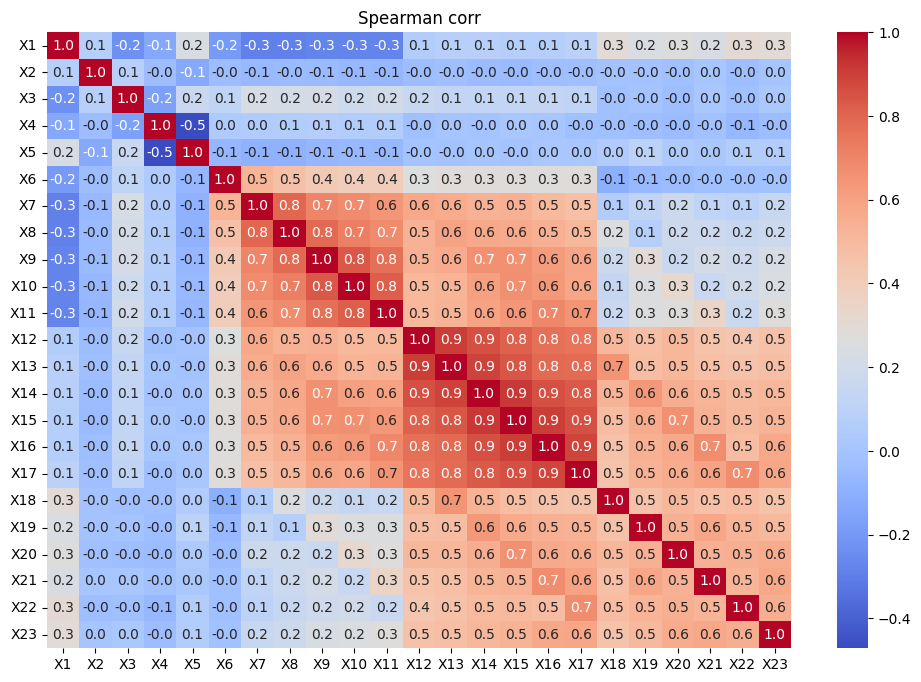

In [30]:
corr_spearman2 = X2.corr(method='spearman')
plt.figure(figsize=(12, 8)) 
sns.heatmap(corr_spearman2, annot=True, cmap='coolwarm', fmt='.1f')

plt.title('Spearman corr')
plt.show()

We can assume we don't have strong collinearity between variables

In [31]:
X2=add_artificial_variables(X2)

C:\Users\Kuba\AppData\Local\Temp\ipykernel_10556\521130096.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"artificial_{i}"] = permuted_column
C:\Users\Kuba\AppData\Local\Temp\ipykernel_10556\521130096.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"artificial_{i}"] = permuted_column
C:\Users\Kuba\AppData\Local\Temp\ipykernel_10556\521130096.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all

In [32]:
old_lr2=logisitic_regression()
old_lr2.fit(X2,y2,a = 0, epsilon=0.001)
pred2_old=old_lr2.predict(X2)
np.mean(y2 == pred2_old)

np.float64(0.569)

In [33]:
my_lr2 = MyLogisticRegression()
my_lr2.fit(X2,y2,a = 0, epsilon=0.001)
pred2_my = my_lr2.predict(X2)
np.mean(y2 == pred2_my)

np.float64(0.819)

In [34]:
model_sk2 = LogisticRegression(solver='liblinear', penalty='l1', max_iter=100)
model_sk2.fit(X2,y2)
pred2_sk=model_sk2.predict(X2)
np.mean(y2 == pred2_sk)

np.float64(0.798)

Zbiór Optical recognition of handwritten digits

In [66]:
optical_recognition_of_handwritten_digits = fetch_ucirepo(id=80) 

In [76]:
X3 = optical_recognition_of_handwritten_digits.data.features
X3

,Attribute1,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9,Attribute10,...,Attribute55,Attribute56,Attribute57,Attribute58,Attribute59,Attribute60,Attribute61,Attribute62,Attribute63,Attribute64
0,0,1,6,15,12,1,0,0,0,7,...,0,0,0,0,6,14,7,1,0,0
1,0,0,10,16,6,0,0,0,0,7,...,3,0,0,0,10,16,15,3,0,0
2,0,0,8,15,16,13,0,0,0,1,...,0,0,0,0,9,14,0,0,0,0
3,0,0,0,3,11,16,0,0,0,0,...,0,0,0,0,0,1,15,2,0,0
4,0,0,5,14,4,0,0,0,0,0,...,12,0,0,0,4,12,14,7,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5615,0,0,4,10,13,6,0,0,0,1,...,4,0,0,0,2,14,15,9,0,0
5616,0,0,6,16,13,11,1,0,0,0,...,1,0,0,0,6,16,14,6,0,0
5617,0,0,1,11,15,1,0,0,0,0,...,0,0,0,0,2,9,13,6,0,0
5618,0,0,2,10,7,0,0,0,0,0,...,2,0,0,0,5,12,16,12,0,0


In [77]:
X3.isna().sum()

Attribute1     0
Attribute2     0
Attribute3     0
Attribute4     0
Attribute5     0
              ..
Attribute60    0
Attribute61    0
Attribute62    0
Attribute63    0
Attribute64    0
Length: 64, dtype: int64

In [78]:
y3=optical_recognition_of_handwritten_digits.data.targets
print(y3.value_counts())
y3=(y3==3).astype(int)
y3=np.array(y3).T[0]
y3.sum()

class
3        572
1        571
4        568
7        566
9        562
6        558
5        558
2        557
0        554
8        554
Name: count, dtype: int64


np.int64(572)

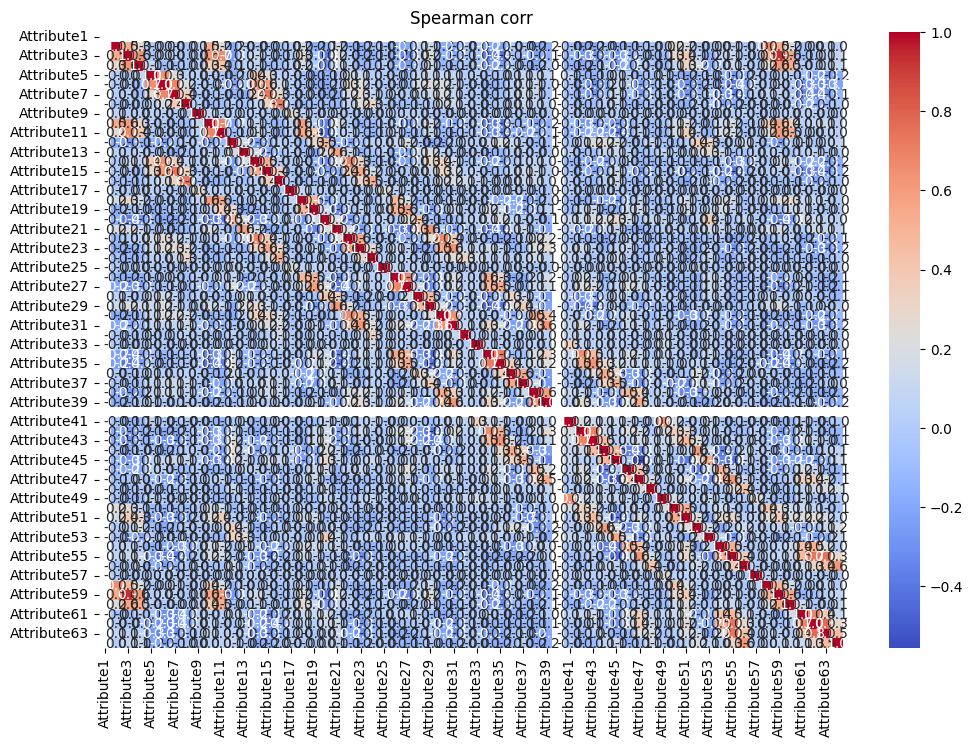

In [79]:
corr_spearman3 = X3.corr(method='spearman')
plt.figure(figsize=(12, 8)) 
sns.heatmap(corr_spearman3, annot=True, cmap='coolwarm', fmt='.1f')

plt.title('Spearman corr')
plt.show()

In [81]:
is_high_corr(corr_spearman3)

Attribute3, Attribute59: 0.94
Attribute62, Attribute63: 0.78


In [82]:
X3=X3.drop(columns=["Attribute62", "Attribute59"])

In [ ]:
X3=X3.iloc[:1000, ]
y3=y3[:1000]
y3.sum()

np.int64(203)

In [83]:
X3=add_artificial_variables(X3)

C:\Users\Kuba\AppData\Local\Temp\ipykernel_10556\521130096.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"artificial_{i}"] = permuted_column
C:\Users\Kuba\AppData\Local\Temp\ipykernel_10556\521130096.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"artificial_{i}"] = permuted_column
C:\Users\Kuba\AppData\Local\Temp\ipykernel_10556\521130096.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all

In [87]:
old_lr3=logisitic_regression()
old_lr3.fit(X3,y3,a = 0, epsilon=0.001)
pred3_old=old_lr3.predict(X3)
np.mean(y3 == pred3_old)

KeyboardInterrupt: 

In [64]:
my_lr3 = MyLogisticRegression()
my_lr3.fit(X3,y3,a = 0, epsilon=0.001)
pred3_my = my_lr3.predict(X3)
np.mean(y3 == pred3_my)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1000 is different from 5620)

In [65]:
model_sk3 = LogisticRegression(solver='liblinear', penalty='l1', max_iter=100)
model_sk3.fit(X3,y3)
pred3_sk=model_sk3.predict(X3)
np.mean(y3 == pred3_sk)

ValueError: Found input variables with inconsistent numbers of samples: [5620, 1000]

Zbiór Connectionist

In [128]:
connectionist_bench_sonar_mines_vs_rocks = fetch_ucirepo(id=151) 

In [129]:
X4 = connectionist_bench_sonar_mines_vs_rocks.data.features
X4

,Attribute1,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9,Attribute10,...,Attribute51,Attribute52,Attribute53,Attribute54,Attribute55,Attribute56,Attribute57,Attribute58,Attribute59,Attribute60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0232,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0125,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0033,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0241,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0156,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,0.0187,0.0346,0.0168,0.0177,0.0393,0.1630,0.2028,0.1694,0.2328,0.2684,...,0.0203,0.0116,0.0098,0.0199,0.0033,0.0101,0.0065,0.0115,0.0193,0.0157
204,0.0323,0.0101,0.0298,0.0564,0.0760,0.0958,0.0990,0.1018,0.1030,0.2154,...,0.0051,0.0061,0.0093,0.0135,0.0063,0.0063,0.0034,0.0032,0.0062,0.0067
205,0.0522,0.0437,0.0180,0.0292,0.0351,0.1171,0.1257,0.1178,0.1258,0.2529,...,0.0155,0.0160,0.0029,0.0051,0.0062,0.0089,0.0140,0.0138,0.0077,0.0031
206,0.0303,0.0353,0.0490,0.0608,0.0167,0.1354,0.1465,0.1123,0.1945,0.2354,...,0.0042,0.0086,0.0046,0.0126,0.0036,0.0035,0.0034,0.0079,0.0036,0.0048


In [130]:
X4.isna().sum()

Attribute1     0
Attribute2     0
Attribute3     0
Attribute4     0
Attribute5     0
Attribute6     0
Attribute7     0
Attribute8     0
Attribute9     0
Attribute10    0
Attribute11    0
Attribute12    0
Attribute13    0
Attribute14    0
Attribute15    0
Attribute16    0
Attribute17    0
Attribute18    0
Attribute19    0
Attribute20    0
Attribute21    0
Attribute22    0
Attribute23    0
Attribute24    0
Attribute25    0
Attribute26    0
Attribute27    0
Attribute28    0
Attribute29    0
Attribute30    0
Attribute31    0
Attribute32    0
Attribute33    0
Attribute34    0
Attribute35    0
Attribute36    0
Attribute37    0
Attribute38    0
Attribute39    0
Attribute40    0
Attribute41    0
Attribute42    0
Attribute43    0
Attribute44    0
Attribute45    0
Attribute46    0
Attribute47    0
Attribute48    0
Attribute49    0
Attribute50    0
Attribute51    0
Attribute52    0
Attribute53    0
Attribute54    0
Attribute55    0
Attribute56    0
Attribute57    0
Attribute58    0
Attribute59   

In [133]:
y4 = connectionist_bench_sonar_mines_vs_rocks.data.targets 
print(y4.value_counts())
y4=(y4=="M").astype(int)
y4=(np.array(y4).T[0])
y4

class
M        111
R         97
Name: count, dtype: int64


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [134]:
corr_spearman4 = X4.corr(method='spearman')

In [135]:
(is_high_corr(corr_spearman4))

Attribute9, Attribute10: 0.84
Attribute10, Attribute11: 0.83
Attribute11, Attribute12: 0.75
Attribute12, Attribute13: 0.80
Attribute14, Attribute15: 0.85
Attribute15, Attribute16: 0.89
Attribute16, Attribute17: 0.85
Attribute17, Attribute18: 0.87
Attribute18, Attribute19: 0.84
Attribute19, Attribute20: 0.85
Attribute20, Attribute21: 0.91
Attribute21, Attribute22: 0.81
Attribute22, Attribute23: 0.83
Attribute23, Attribute24: 0.83
Attribute24, Attribute25: 0.84
Attribute25, Attribute26: 0.83
Attribute26, Attribute27: 0.85
Attribute27, Attribute28: 0.79
Attribute28, Attribute29: 0.80
Attribute29, Attribute30: 0.81
Attribute30, Attribute31: 0.79
Attribute31, Attribute32: 0.81
Attribute32, Attribute33: 0.77
Attribute33, Attribute34: 0.80
Attribute34, Attribute35: 0.81
Attribute35, Attribute36: 0.81
Attribute36, Attribute37: 0.84
Attribute37, Attribute38: 0.79
Attribute38, Attribute39: 0.76
Attribute39, Attribute40: 0.76
Attribute41, Attribute42: 0.77
Attribute45, Attribute46: 0.79
Attribute

In [136]:
X4=add_artificial_variables(X4)

In [137]:
old_lr4=logisitic_regression()
old_lr4.fit(X4,y4,a = 0, epsilon=0.001)
pred4_old=old_lr4.predict(X4)
np.mean(y4 == pred4_old)

np.float64(0.6105769230769231)

In [138]:
my_lr4 = MyLogisticRegression()
my_lr4.fit(X4,y4,a = 0, epsilon=0.001)
pred4_my = my_lr4.predict(X4)
np.mean(y4 == pred4_my)

np.float64(0.8461538461538461)

In [140]:
model_sk4= LogisticRegression(solver='liblinear', penalty='l1', max_iter=100)
model_sk4.fit(X4,y4)
pred4_sk=model_sk4.predict(X4)
np.mean(y4 == pred4_sk)

np.float64(0.8076923076923077)

Synthetic data

In [ ]:
def generate_synthetic_dataset(p, n, d, g):
    y = np.random.binomial(1, p, size=n)

    S = np.fromfunction(lambda i, j: g ** np.abs(i - j), (d, d))
    
    m0 = np.zeros(d)
    m1 = np.array([1 / (i + 1) for i in range(d)])
    x_0 = np.random.multivariate_normal(m0, S, size=n)
    x_1 = np.random.multivariate_normal(m1, S, size=n)
    X= np.where(np.expand_dims(y, axis=1) == 0, x_0, x_1)
    
    return X, y

In [104]:
X5, y5=generate_synthetic_dataset(0.5, 100, 30, 0.1)

In [105]:
old_lr5=logisitic_regression()
old_lr5.fit(X5,y5,a = 0, epsilon=0.001)
pred5_old=old_lr5.predict(X5)
np.mean(y5 == pred5_old)

np.float64(0.86)

In [106]:
my_lr5 = MyLogisticRegression()
my_lr5.fit(X5,y5,a = 0, epsilon=0.001)
pred5_my = my_lr5.predict(X5)
np.mean(y5 == pred5_my)

np.float64(0.86)

In [107]:
model_sk5 = LogisticRegression(solver='liblinear', penalty='l1', max_iter=100)
model_sk5.fit(X5,y5)
pred5_sk=model_sk5.predict(X5)
np.mean(y5 == pred5_sk)

np.float64(0.88)